# Comparing Model Robustness Using the Data Drift Metric

This notebook demonstrates how to evaluate the robustness of different 
machine learning models when the input data distribution changes over time.

We use:
- **One fixed training dataset**
- **50 artificially drifted datasets**
- **Three models trained on the same reference data:**
  - Logistic Regression  
  - Random Forest  
  - Support Vector Machine (SVM)

We combine:
- The **data drift metric** 
- The **model accuracy over time**

The goal is to analyze:
**Which model is most robust to data drift?**  
**Which model is most sensitive to drift?**  
**Is higher accuracy correlated with drift sensitivity?**

## 1. Load Drift Scores and Model Results

We start by loading:
- the **drift scores** generated by our metric  
- the **accuracy results** for each model on each drifted dataset  

Each CSV contains 50 rows, one for each synthetic drift scenario.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load drift metric
drift = pd.read_csv("./tests/data/measures/data_drift.csv")

# Load model accuracies
logreg = pd.read_csv("./tests/data/measures/results_logreg.csv")
rf = pd.read_csv("./tests/data/measures/results_randomforest.csv")
svm = pd.read_csv("./tests/data/measures/results_svm.csv")

drift.head()

,name,score,time,feature_pid
0,data_drift,0.300000,2016-03-01T00:00:00,acc2c01d-248a-45a4-af5b-f3c74d3878c1
1,data_drift,0.233333,2016-03-02T00:00:00,fa734345-2de4-41cc-b93b-b4cfcb5953c9
2,data_drift,0.133333,2016-03-03T00:00:00,6d7bb574-2a22-450e-8f17-0d4438416d0f
3,data_drift,0.266667,2016-03-04T00:00:00,71845ecc-4ec3-4f86-8d4e-59a2e14651bb
4,data_drift,0.233333,2016-03-05T00:00:00,1867253b-47e1-4192-aba3-b03da1ee4bde


The table above shows the first drift scores.  
A value close to **0** means "little drift", while a value close to **1** means "many columns drifted."

We now load the model accuracy results (one CSV per model).

Next, we sort and align all CSV files by their timestamp so the drift scores and model accuracies match correctly.

In [2]:
# Convert time columns to datetime for alignment
drift["time"] = pd.to_datetime(drift["time"])
logreg["time"] = pd.to_datetime(logreg["time"])
rf["time"] = pd.to_datetime(rf["time"])
svm["time"] = pd.to_datetime(svm["time"])

# Sort by time
drift = drift.sort_values("time")
logreg = logreg.sort_values("time")
rf = rf.sort_values("time")
svm = svm.sort_values("time")

## 2. Visualizing Drift Over Time

Here we plot how the drift changes day by day across the 50 artificially drifted datasets.

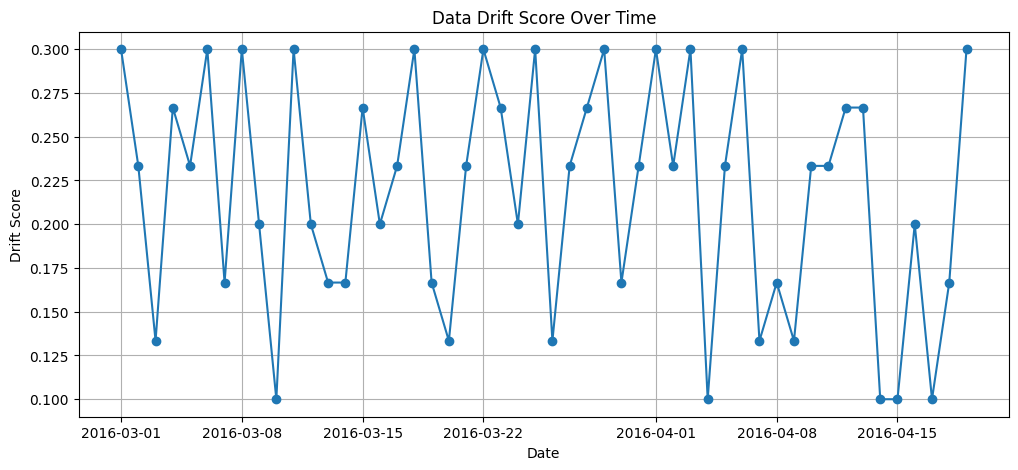

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(drift["time"], drift["score"], marker="o")
plt.title("Data Drift Score Over Time")
plt.xlabel("Date")
plt.ylabel("Drift Score")
plt.grid(True)
plt.show()

## 3. Accuracy of Each Model Over Time

Each model was evaluated on the same 50 drifted datasets.  
Here we want to see how each model reacts when the data distribution changes.

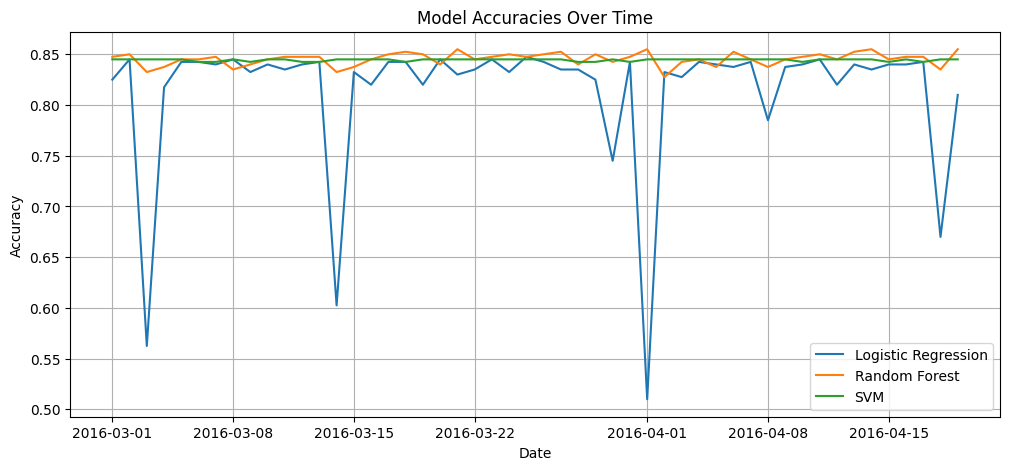

In [4]:
plt.figure(figsize=(12, 5))

plt.plot(logreg["time"], logreg["accuracy"], label="Logistic Regression")
plt.plot(rf["time"], rf["accuracy"], label="Random Forest")
plt.plot(svm["time"], svm["accuracy"], label="SVM")

plt.title("Model Accuracies Over Time")
plt.xlabel("Date")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## 4. Overlaying Accuracy with Drift Score

To visually inspect robustness, we overlay:
- the drift curve  
- the accuracy curve of each model  

A robust model should show **stable accuracy even when drift increases**.

In [5]:
merged_logreg = pd.merge(drift, logreg, on="time")
merged_rf = pd.merge(drift, rf, on="time")
merged_svm = pd.merge(drift, svm, on="time")

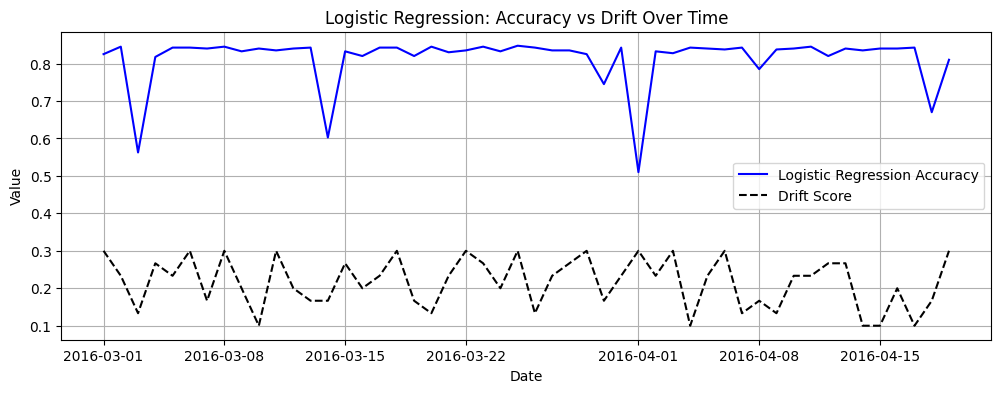

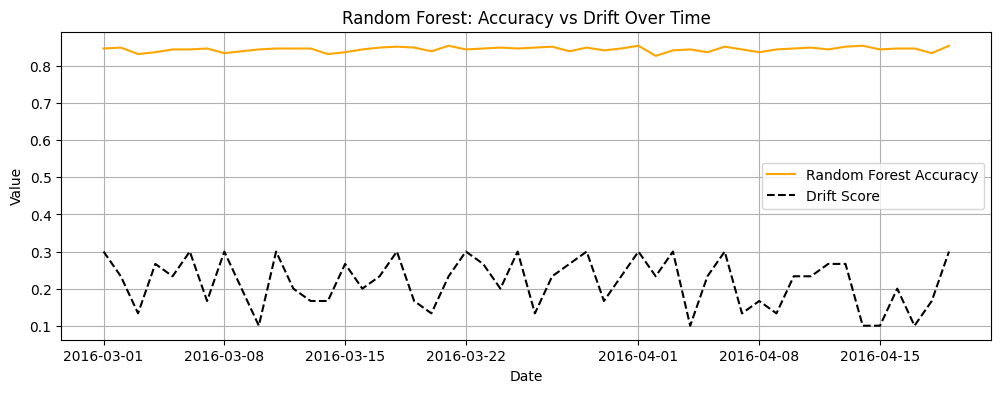

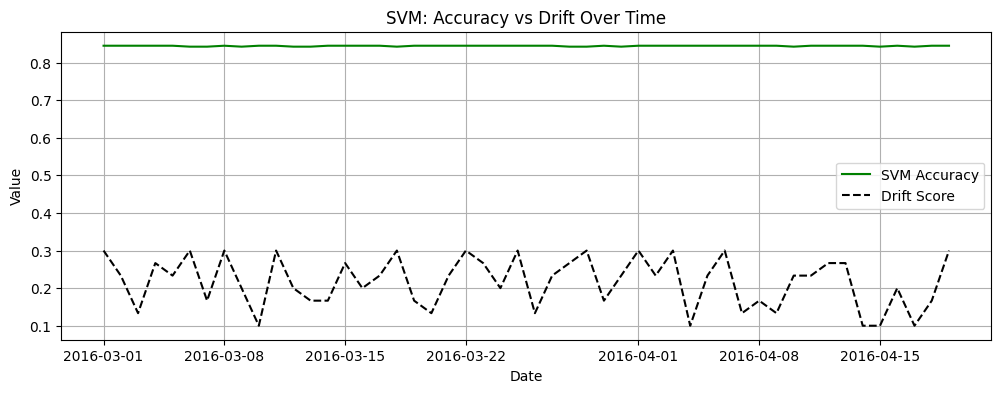

In [6]:
def plot_overlay(df, model_name, color_acc, color_drift):
    plt.figure(figsize=(12, 4))
    plt.plot(
        df["time"], df["accuracy"], label=f"{model_name} Accuracy", color=color_acc
    )
    plt.plot(
        df["time"], df["score"], label="Drift Score", color=color_drift, linestyle="--"
    )
    plt.title(f"{model_name}: Accuracy vs Drift Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_overlay(merged_logreg, "Logistic Regression", "blue", "black")
plot_overlay(merged_rf, "Random Forest", "orange", "black")
plot_overlay(merged_svm, "SVM", "green", "black")

## 5. Correlation Between Drift and Accuracy

We compute the correlation between the **drift score** and each model's **accuracy**

A lower correlation means that the model is **robust**  
A higher correlation means that the model is **sensitive to drift**

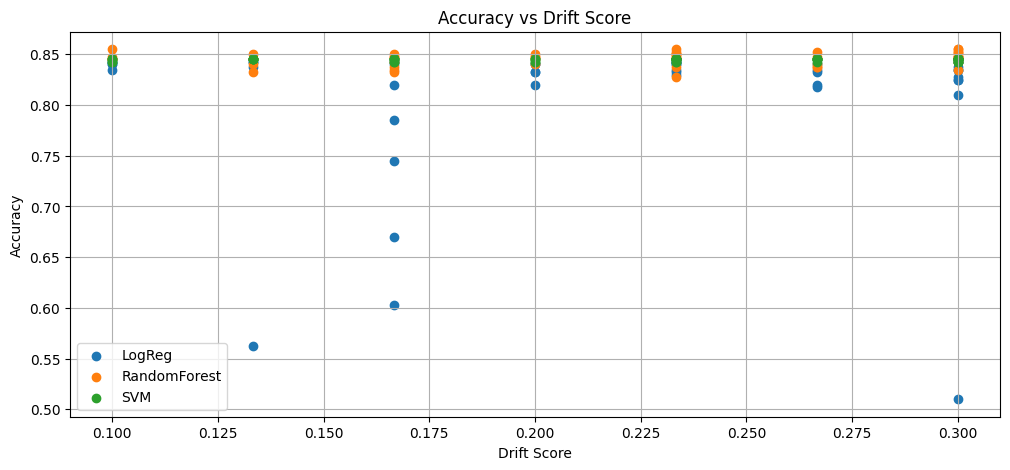

In [7]:
plt.figure(figsize=(12, 5))
plt.scatter(merged_logreg["score"], merged_logreg["accuracy"], label="LogReg")
plt.scatter(merged_rf["score"], merged_rf["accuracy"], label="RandomForest")
plt.scatter(merged_svm["score"], merged_svm["accuracy"], label="SVM")

plt.title("Accuracy vs Drift Score")
plt.xlabel("Drift Score")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Average Accuracy Over All Drifted Datasets

This plot shows how each model performs on average, independently of drift.
It measures overall predictive performance, not robustness to drift.

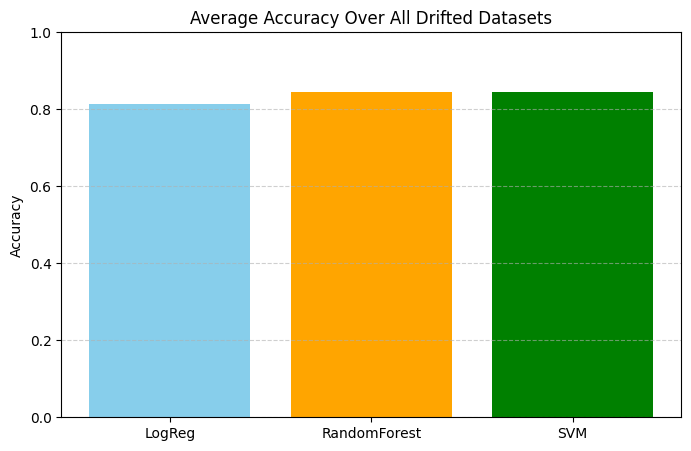

In [8]:
mean_logreg = logreg["accuracy"].mean()
mean_rf = rf["accuracy"].mean()
mean_svm = svm["accuracy"].mean()

models = ["LogReg", "RandomForest", "SVM"]
means = [mean_logreg, mean_rf, mean_svm]

plt.figure(figsize=(8, 5))
plt.bar(models, means, color=["skyblue", "orange", "green"])
plt.title("Average Accuracy Over All Drifted Datasets")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

## 6. Final Comparison: Accuracy vs Drift Robustness

In this last visualization, we compare all models side-by-side in terms of:
- **Average accuracy**
- **Sensitivity to drift**

This gives us a complete picture of each model's strengths and weaknesses.

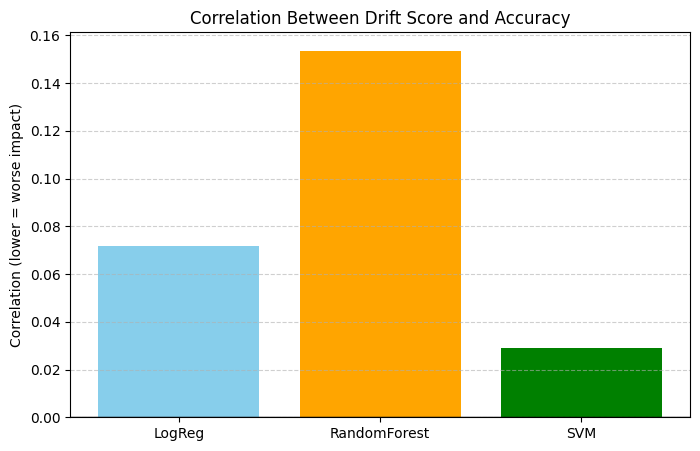

In [9]:
corr_logreg = merged_logreg["score"].corr(merged_logreg["accuracy"])
corr_rf = merged_rf["score"].corr(merged_rf["accuracy"])
corr_svm = merged_svm["score"].corr(merged_svm["accuracy"])

correlations = [corr_logreg, corr_rf, corr_svm]

plt.figure(figsize=(8, 5))
plt.bar(models, correlations, color=["skyblue", "orange", "green"])
plt.title("Correlation Between Drift Score and Accuracy")
plt.ylabel("Correlation (lower = worse impact)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.show()

### Interpretation of the Correlation Plot

This plot shows how strong each model’s accuracy is affected by the drift score.

- **Lower correlation = better robustness to drift**
- **Higher correlation = more drift-sensitive**

# Final Conclusion

Our experiment shows that:

### Random Forest  
- Highest accuracy overall  
- But **most sensitive to data drift**  
- Meaning: great performance in stable environments, but risky in production when data changes

### Support Vector Machine  
- Slightly lower accuracy  
- **Most robust to drift**  
- Best choice when data distribution is unstable

### Logistic Regression  
- Lowest accuracy  
- Moderate robustness  
- Simple model but more stable than Random Forest